import stuff here

In [1]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("C:\\Users\\Tassili\\Documents\\GitHub\\FSC-optimization")
from QCLP_formulation import *
import networkx as nx
import os
os.environ['NEOS_EMAIL'] = 'malikbf5@gmail.com' 


# General two-armed Bernoulli Bandits

  Credits: Andrea Mazzolini, Alberto Pezzotta 

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="200">
</div>

There is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="200">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll consider two possible states to be in (state A and B) where each state is characterized by its winning probabilities for each arm which we'll denote as $\theta$, so state A is characterized by ($\theta_{A,1}, \theta_{A,2}$) and for B ($\theta_{B,1}, \theta_{B,2}$)

We select some rules for picking the winning probabilities
* We keep the gap $\Delta$ the same for both where $\Delta_s = |\theta_{s,1} - \theta_{s,2}|$ so that there's no big difference in terms of regret of not picking the optimal action in both bandits
* We pick $\theta_{A,1} > \theta_{A,2}$ and $\theta_{B,1} < \theta_{B,2}$ so the optimal action is different in the two states
* Make the standard deviation in each arm different 
<br>

This leaves us with the following region of values for the winning probabilities:


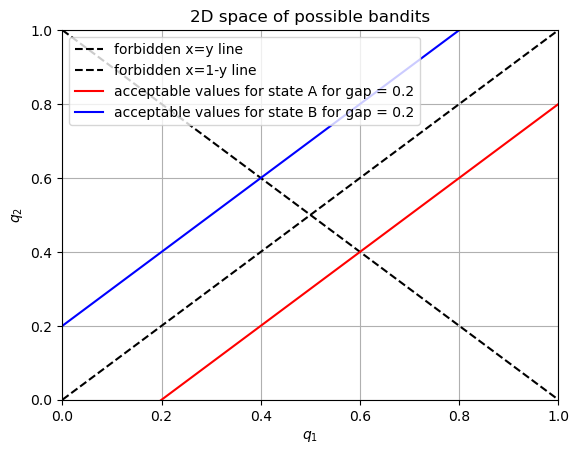

In [2]:
# fix the gap
gap = 0.2
# forbidden values where q1 = q2
plt.plot([0, 1], [0, 1], 'k--', label='forbidden x=y line')
# forbidden values where the states are symmetric
plt.plot([0, 1], [1, 0], 'k--', label='forbidden x=1-y line')
# acceptable values for state A for gap 
plt.plot([0, 1], [- gap, 1-gap], 'r', label=f'acceptable values for state A for gap = {gap}')
# acceptable values for state B for gap
plt.plot([0, 1], [ gap, 1+gap], 'b', label=f'acceptable values for state B for gap = {gap}')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

We pick the following states

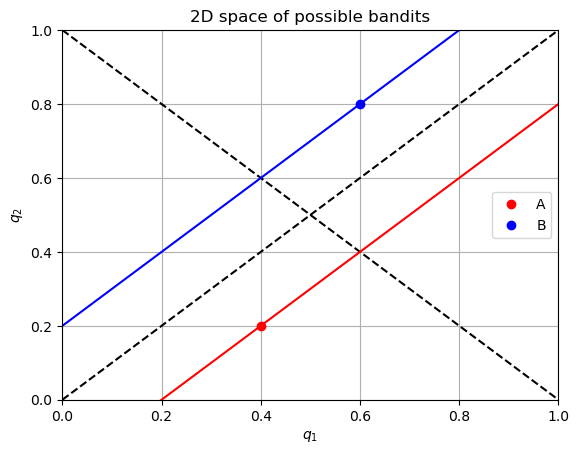

In [3]:
# for gap 
gap = 0.2
# state A
x1 = 0.4
y1 = x1 - gap
# state B
x2 = 0.6
y2 = x2 + gap
# forbidden values where q1 = q2
plt.plot([0, 1], [0, 1], 'k--')
# forbidden values where the states are symmetric
plt.plot([0, 1], [1, 0], 'k--')
# acceptable values for state A for gap 
plt.plot([0, 1], [- gap, 1-gap], 'r')
# acceptable values for state B for gap
plt.plot([0, 1], [ gap, 1+gap], 'b')
# plot the points
plt.plot(x1, y1, 'ro', label = 'A')
plt.plot(x2, y2, 'bo', label = 'B')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

In [9]:
#Define POMDP 

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = x1, y1
# state B
reward_model[1, 0], reward_model[1, 1] = x2, y2

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
# state A
# if action 0 is taken
observation_model[0, 0, 1], observation_model[0, 0, 0] = x1, 1 - x1
# if action 1 is taken
observation_model[0, 1, 1], observation_model[0, 1, 0] = y1, 1 - y1
# state B
# if action 0 is taken
observation_model[1, 0, 1], observation_model[1, 0, 0] = x2, 1 - x2
# if action 1 is taken
observation_model[1, 1, 1], observation_model[1, 1, 0] = y2, 1 - y2

Visualizing POMDP parameter values

In [10]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df = state_transition_model_df.rename_axis("(s',a,s)", axis="columns")
state_transition_model_df

"(s',a,s)","('A', 1, 'A')","('A', 1, 'B')","('A', 2, 'A')","('A', 2, 'B')","('B', 1, 'A')","('B', 1, 'B')","('B', 2, 'A')","('B', 2, 'B')"
Transition probability,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [11]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.4,0.2
B,0.6,0.8


In [13]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability'])
observation_model_df.rename_axis("(s',a,o)", axis="index")

,"('A', 1, 0)","('A', 1, 1)","('A', 2, 0)","('A', 2, 1)","('B', 1, 0)","('B', 1, 1)","('B', 2, 0)","('B', 2, 1)"
"(s',a,o)",,,,,,,,
Observation probability,0.6,0.4,0.8,0.2,0.4,0.6,0.2,0.8


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="600">
</div>

Where:  
The variable $x(q', a, q, o)$ represents $P(q', a|q, o)$  
The variable $y(q, s)$ represents $V(q, s)$  
$q_0$ is the initial controller node  
$o_k$ is an arbitrary fixed observation  

Note that $P(q', a|q, o)= P(q'|q, a, o) \pi(a|q)$ 

And $\sum{q'} P(q', a|q, o) = \pi(a|q)$

Parameters <br>
$\gamma$: discount factor <br>
$b_0(s)$: initial distribution of states <br>
$\rho(q)$: initial distribution over nodes in objective function, either $\rho(q_0) = 1$ or uniform

In [14]:
# discount factor
gamma = 0.9

# b_0(s)
b0 = np.ones((num_states)) / num_states # uniform initial distribution over states

# distribution over nodes
# this fixes the objective function to maximize over y(q_0,s)
obj = "first node" 
# this fixes the objective function to maximize over all y(q,s) with uniform distribution
# obj = "all nodes" 

## Generating instances 
where the x variables are restarted randomly to cover more of the search space

In [9]:
number_instances = 3
controller_size_list = [2,3,4,5,6]
ssol = opt_instances(controller_size_list, number_instances,
                     num_states, num_actions, num_observations, 
                     b0, gamma, state_transition_model, reward_model, 
                     observation_model, obj = obj)
ssol["dataframe"]

ERROR: Error loading NEOS solution into model  NEOS log: Job 14893122
dispatched password: AJmnoLsO
    ---------- Begin Solver Output -----------
    Condor submit: 'neos.submit' Condor submit: 'watchdog.submit' Job
    submitted to NEOS HTCondor pool.
Traceback (most recent call last):
  File "c:\Users\Tassili\anaconda3\Lib\site-packages\pyomo\neos\plugins\kestrel_plugin.py", line 233, in _perform_wait_any
    _model.solutions.load_from(
  File "c:\Users\Tassili\anaconda3\Lib\site-packages\pyomo\core\base\PyomoModel.py", line 230, in load_from
    raise ValueError(
ValueError: Cannot load a SolverResults object with bad status: error
ERROR: evaluating object as numeric value: y[0,0]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object y[0,0]
ERROR: evaluating object as numeric value: obj
        (object: <class 'pyomo.core.base.objective.ScalarObjective'>)
    No value for uninitialized NumericValue object y[0,0]


ValueError: No value for uninitialized NumericValue object y[0,0]

In [ ]:
ssol[2]["action select df"]

"(a,q)","(0, 0)","(0, 1)","(1, 0)","(1, 1)"
P(a | q),1.0,0.0,0.0,1.0
P(a | q),1.0,-0.0,0.0,1.0
P(a | q),0.0,1.0,1.0,0.0


In [ ]:
ssol[3]["action select df"]

"(a,q)","(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)"
P(a | q),1.0,-0.0,0.027541,0.0,1.0,0.972459
P(a | q),0.0,1.0,-0.0,1.0,0.0,1.0
P(a | q),0.0,-0.0,1.0,1.0,1.0,0.0


In [ ]:
ssol[4]["action select df"]

"(a,q)","(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)"
P(a | q),0.0,1.0,1.0,-0.0,1.0,0.0,0.0,1.0
P(a | q),0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
P(a | q),0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0


In [ ]:
ssol[5]["action select df"]

"(a,q)","(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)"
P(a | q),0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
P(a | q),0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
P(a | q),1.0,0.44812,0.934201,0.0,-0.0,0.0,0.55188,0.065799,1.0,1.0


In [ ]:
ssol[5]["value df"]

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)","(3, 0)","(3, 1)","(4, 0)","(4, 1)",objective funct,mean value,value for nodes V(q),value for states V(s)
"V(q,s)",3.575088,7.763358,3.935267,6.524639,3.308803,7.939071,2.970774,7.974537,3.860421,6.929038,5.669223,5.495474,"[5.669, 5.23, 5.624, 5.473, 5.395]","[3.53, 7.426]"
"V(q,s)",3.559168,7.722296,3.876138,6.922351,3.774415,7.262086,3.921016,6.668956,3.157493,7.883713,5.640732,5.489851,"[5.641, 5.399, 5.518, 5.295, 5.521]","[3.658, 7.292]"
"V(q,s)",3.448392,7.448388,3.319454,7.53603,3.450221,7.298681,3.234753,7.822364,3.066172,7.891186,5.448390,5.451275,"[5.448, 5.428, 5.374, 5.529, 5.479]","[3.304, 7.599]"


In [ ]:
ssol[6]["action select df"]

"(a,q)","(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)","(1, 5)"
P(a | q),0.0,0.0,0.036599,0.0,0.0,1.0,1.0,1.0,0.963401,1.0,1.0,0.0
P(a | q),0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
P(a | q),0.0,0.753554,0.0,1.0,1.0,0.0,1.0,0.246446,1.0,0.0,0.0,1.0


In [ ]:
ssol[6]["value df"]

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)","(3, 0)","(3, 1)","(4, 0)","(4, 1)","(5, 0)","(5, 1)",objective funct,mean value,value for nodes V(q),value for states V(s)
"V(q,s)",3.598179,7.713422,3.351121,7.937339,3.450797,7.767921,3.113511,7.984615,2.78169,7.994298,3.881913,6.658545,5.655801,5.529935,"[5.656, 5.644, 5.609, 5.549, 5.388, 5.27]","[3.363, 7.676]"
"V(q,s)",3.575088,7.763358,3.935269,6.524625,3.86042,6.929045,2.970803,7.974535,3.308808,7.939069,3.594535,7.255114,5.669223,5.484607,"[5.669, 5.23, 5.395, 5.473, 5.624, 5.425]","[3.541, 7.398]"
"V(q,s)",3.57509,7.763356,3.547417,7.132106,3.308803,7.939071,3.860424,6.929029,3.935267,6.524643,2.970771,7.974537,5.669223,5.471518,"[5.669, 5.34, 5.624, 5.395, 5.23, 5.473]","[3.533, 7.377]"


Bayesian sol

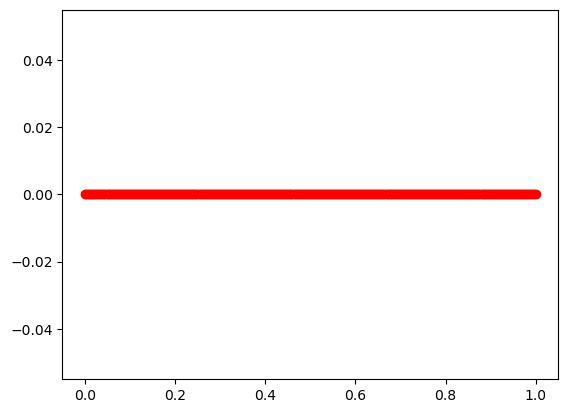

In [15]:
# construct belief points on segment
def belief_points(num_points):
    # define segment
    segment = (0,1)
    # return list of belief points where first element if belief to be in the first state
    # and second element is belief to be in the second state
    return [(point, 1 - point) for point in list(np.linspace(segment[0],segment[1],num_points))]
b = belief_points(300)
# plot first element in points in b on segment
plt.plot([point[0] for point in b], [0 for point in b], 'ro')

In [16]:
# belief update function
def belief_update(belief_point, action, observation, state_transition_model, observation_model):
    # belief update formula
    new_belief_point = [0 for i in range(len(belief_point))]
    for sprime in range(len(belief_point)):
        # sum_s b(s) * P(s'|s,a) * O(o|s', a)
        numerator = sum(belief_point[state] *
                        observation_model[sprime, action, observation] *
                        state_transition_model[sprime, action, state] 
                        for state in range(len(belief_point)))
        # sum_s,s' b(s) * P(s'|s,a) * O(o|s', a)
        denominator = sum(belief_point[state] *
                        observation_model[sp, action, observation] *
                        state_transition_model[sp, action, state] 
                        for state,sp in product(range(len(belief_point)),range(len(belief_point)))
                        )
        if denominator != 0:
            new_belief_point[sprime] = numerator / denominator
    return tuple(new_belief_point)
# new_belief_point = belief_update(b[0], 1, 0, state_transition_model, observation_model)
# type(new_belief_point)

In [17]:
# closest belief function
def closest_belief(belief_point, belief_list):
    return min(belief_list, key = lambda x: sum((x[i] - belief_point[i])**2 for i in range(len(belief_point))))
# type(closest_belief((0.6,0.4),[(0,1),(1,0)]))

In [18]:
# value iteration algorithm
def value_iteration_bp(beliefpoints, tol, state_transition_model, observation_model, rewards, num_states, num_actions, num_observations, gamma):
    # initialize value function V(b) = 0 for each b
    valuefun = { bp: 0 for bp in beliefpoints}
    tempvaluefun = { bp: 0 for bp in beliefpoints}
    # best action
    bestaction = {bp: 0 for bp in beliefpoints}
    # value iteration algo
    # i = 0
    while True:
        # delta which tells us to stop after exceeding tolerance
        delta = 0
        #print(i)
        for bp in beliefpoints:
            # bellman operator
            quality = [0 for i in range(num_actions)]
            for action in range(num_actions):
                # sum_s,s',y b(s) * P(s'| s, a) * f(y| s', a) * (r(s,a) + gamma * V(b'(.|a, y)))
                quality[action] = sum(
                bp[state]* 
                observation_model[stateprime, action, obs]* 
                state_transition_model[stateprime, action, state]*
                (rewards[state,action]+
                gamma *
                valuefun[closest_belief(
                belief_update(bp, action, obs, state_transition_model, observation_model),
                beliefpoints
                )]
                ) 
                for state, stateprime, obs in 
                product(range(num_states), range(num_states), range(num_observations)))
            # take max over actions and update V'
            tempvaluefun[bp] = max(quality)
            # update best action
            bestaction[bp] = quality.index(max(quality))
            # update delta = max(delta, |V(b) - V'(b)|)
            delta = max(delta, abs(tempvaluefun[bp] - valuefun[bp]))
        # update value function V <- V'
        valuefun = tempvaluefun.copy()
        # print(delta)
        if delta <= tol:
            break
        # i += 1
    return valuefun, bestaction

In [19]:
v,ba = value_iteration_bp(b,10**-8, 
                        state_transition_model, observation_model, reward_model, 
                        num_states, num_actions, num_observations, 
                        gamma)

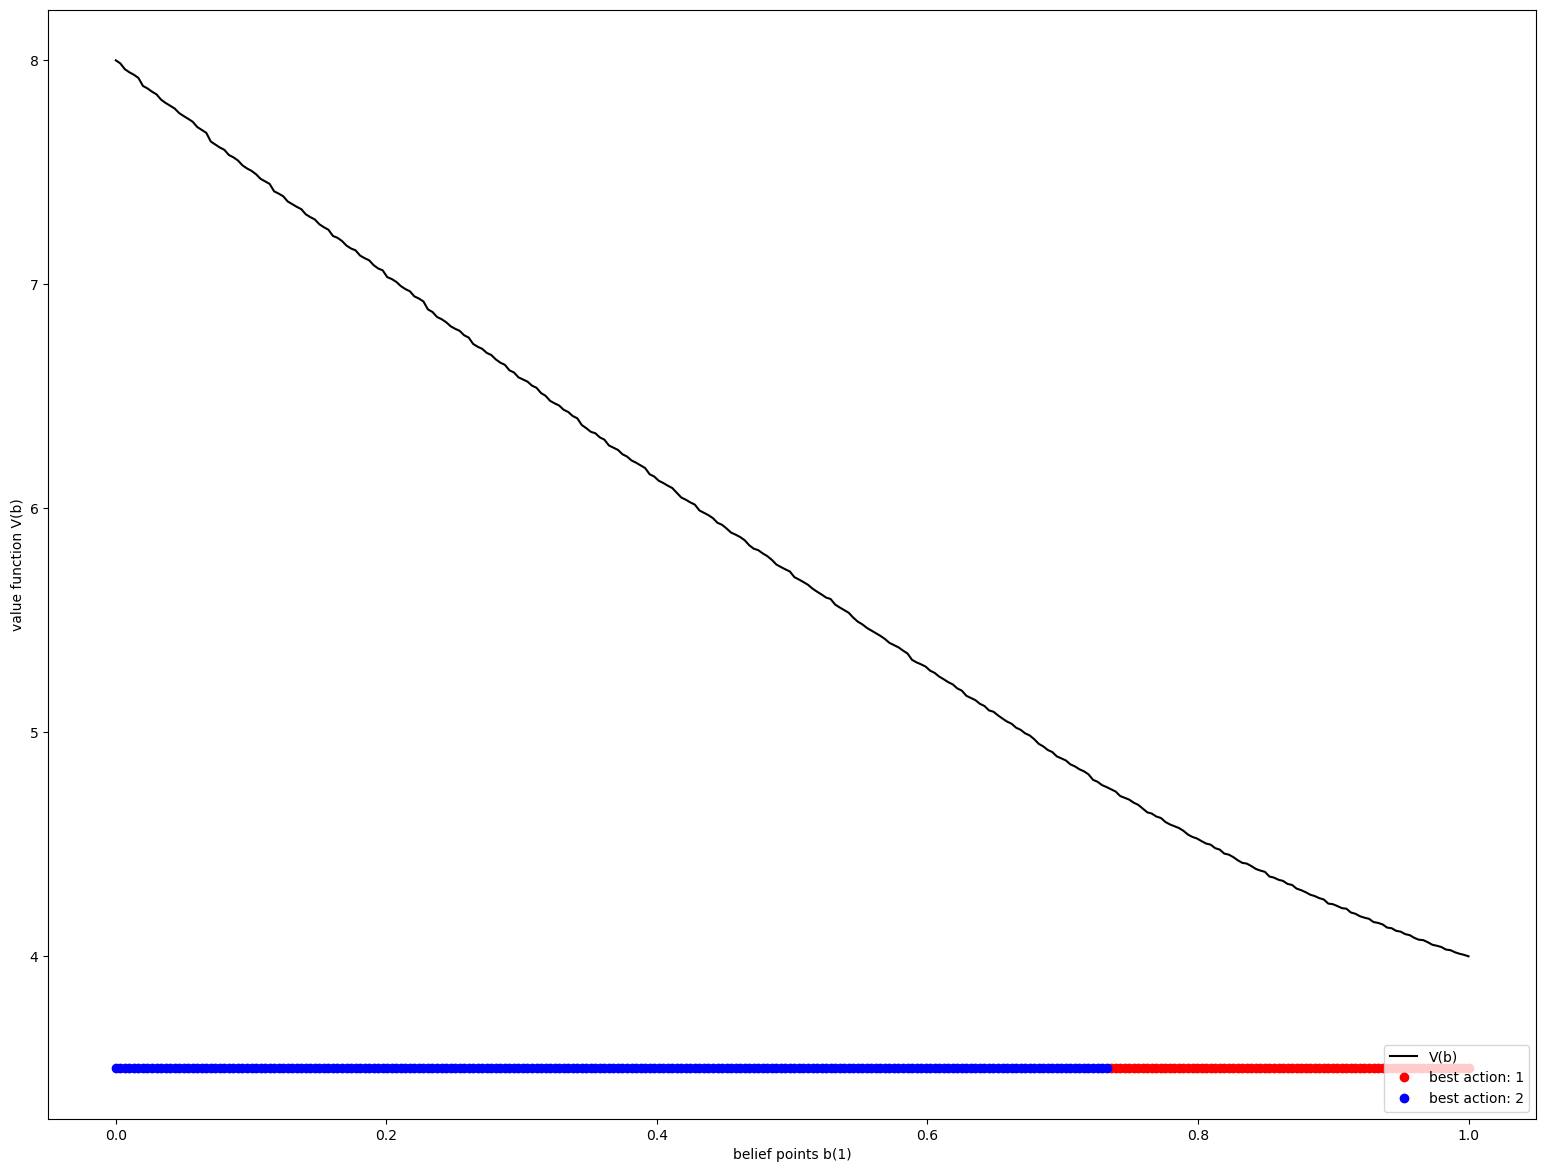

In [20]:
plt.figure(figsize=(6.4*3, 4.8*3))
# plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")
# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")
# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")
# legend
plt.xlabel("belief points b(1)")
plt.ylabel("value function V(b)")
plt.legend(loc = "lower right")
plt.show()

## Comparison with FSC
for each $b_i \in B$ we compare $V(b_i)$ with the objective function where the initial distribution over states $b_0 = b_i$


In [21]:
# compare with FSC QCLP
number_instances = 3
controller_size_list = [2, 3, 4]
# dictionary containing for each FSC size the objective function
valuefsc = {fsc_size: [] for fsc_size in controller_size_list}
# choosing a random sample of belief points for less optimization calls
sample_size = 10
# evenly spaced belief points on segment
sample_b = belief_points(sample_size)
# in case the belief points generated are not in the other list of belief points
sample_b = [ closest_belief(bp,b) for bp in sample_b]
# sort the sample for clean plotting
# sample_b.sort(key= lambda x: x[0])
for fsc_size in controller_size_list:
    for bp in sample_b:
        # b0 distribution over states according to belief point
        bdist = np.array(bp)
        # run QCLP optimization
        sol = opt_instances([fsc_size],
                            number_instances,num_states, num_actions, num_observations, 
                            bdist, gamma, 
                            state_transition_model, reward_model, observation_model, 
                            obj = obj)
        # add max objective funciton under this belief point 
        valuefsc[fsc_size].append(sol[fsc_size]["max obj"])

In [29]:
valuefsc

{2: [8.000000000000025,
  7.337793182917127,
  6.675585284280953,
  5.993311103337631,
  5.630303450294748,
  4.889632107023415,
  4.668896321070239,
  4.44147157190636,
  4.2207357859531855,
  4.000000000000004],
 3: [8.000000129722887,
  7.337792642140463,
  6.675585284282345,
  5.993311036863448,
  5.832013156591254,
  4.889632107023416,
  4.668896321070238,
  4.441471571933934,
  4.220735785953178,
  4.0000000000000036],
 4: [8.00000000000001,
  7.4217644459404095,
  6.887453506088473,
  6.353407336522666,
  5.895511215212509,
  4.889632107023417,
  4.668896321070237,
  4.441475569375028,
  4.220735785953181,
  4.000000002228862]}

In [27]:
import math
i = 0
for bp in sample_b:
    isequal = True
    for fsc_size_first in controller_size_list:
        for fsc_size_second in controller_size_list:
            if fsc_size_first != fsc_size_second:
                if not math.isclose(valuefsc[fsc_size_first][i], valuefsc[fsc_size_second][i]):
                    isequal = False
                    break
    if isequal:
        print(f"belief point: {bp}, value: {valuefsc[controller_size_list[0]][i]}")
    i += 1

belief point: (0.5551839464882943, 0.4448160535117057), value: 4.889632107023415
belief point: (0.6655518394648829, 0.33444816053511706), value: 4.668896321070239
belief point: (0.8896321070234113, 0.11036789297658867), value: 4.2207357859531855
belief point: (1.0, 0.0), value: 4.000000000000004


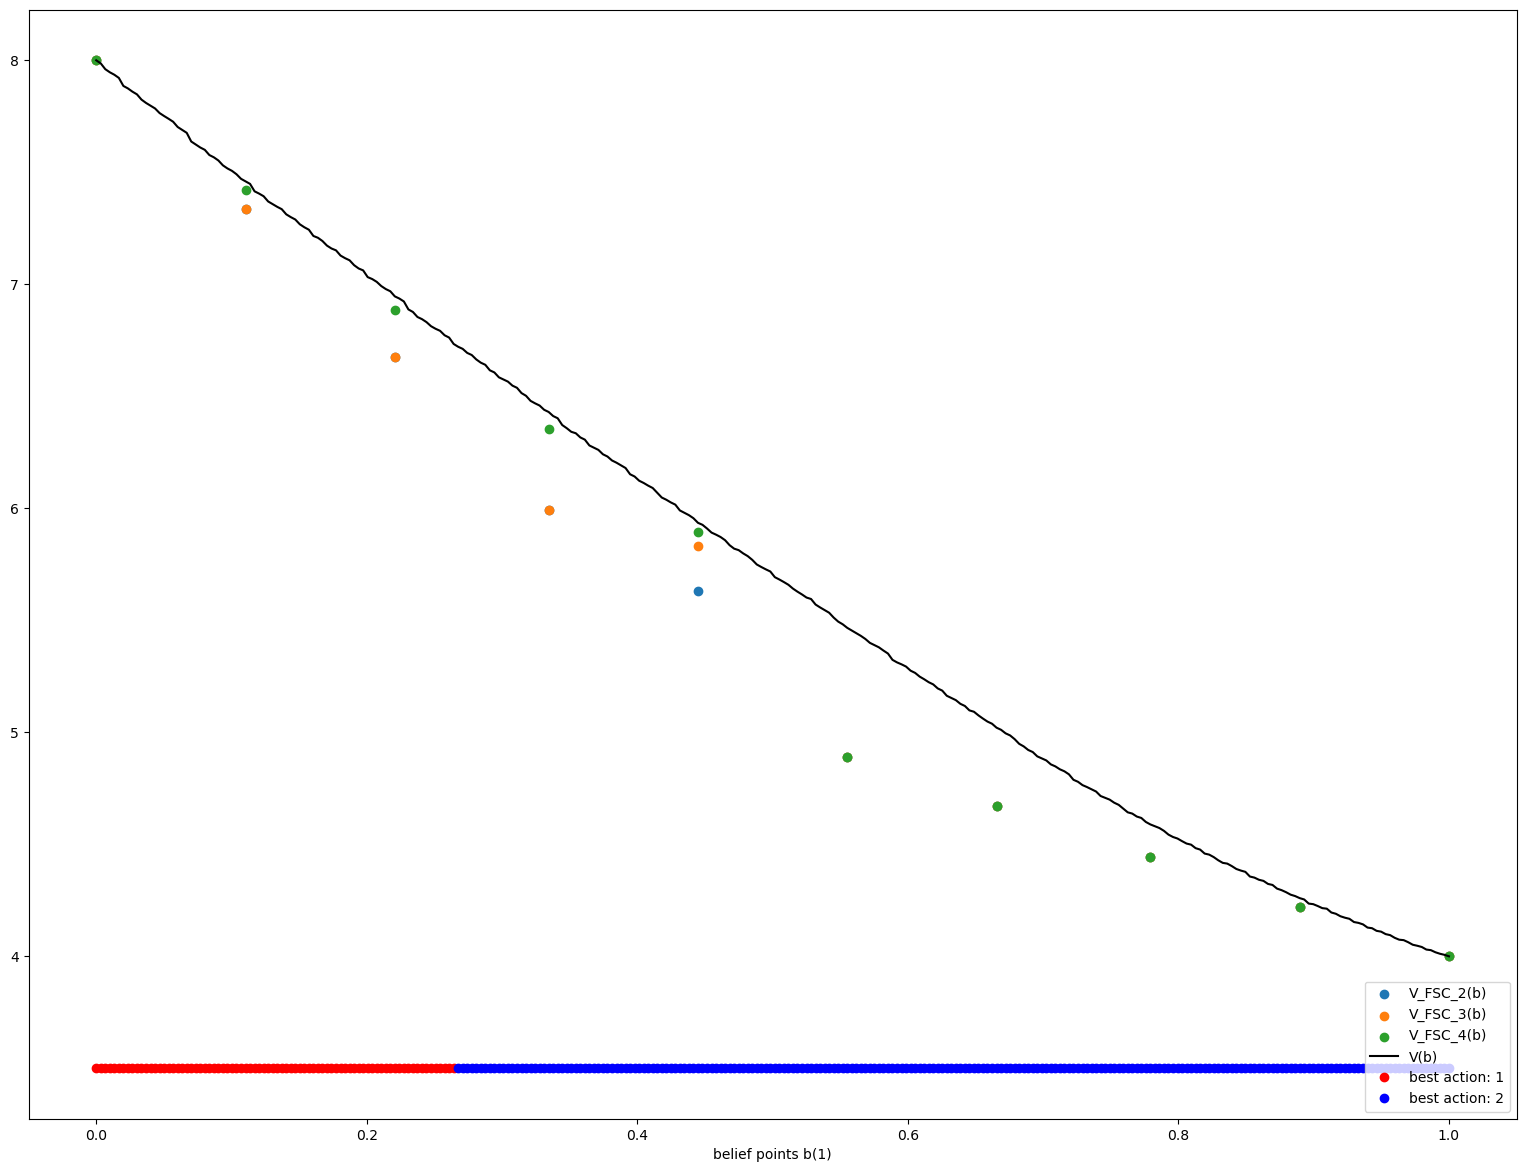

In [ ]:
plt.figure(figsize=(6.4*3, 4.8*3))
# plot objective function for each size
for fsc_size in controller_size_list:
    plt.scatter([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], 'k', label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[1] for point in b if ba[point] == 0],
    [min([valuefsc[fsc_size] for fsc_size in controller_size_list]) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {1}")

# plot belief points with best action = 1
plt.plot(
    [point[1] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {2}")

# legend
plt.xlabel("belief points b(1)")
plt.legend(loc = "lower right")
plt.show()